In [5]:
# Importamos las librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_validate

from sklearn.impute import SimpleImputer

In [6]:
# Esta linea permite que los graficos sean renderizados directamente en nuestro Notebook
## Carguemos en un pandas dataframe nuestra base de datos
%matplotlib inline

# 1 Importar los datasets 

In [8]:
train = pd.read_csv('../../house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('../../house-prices-advanced-regression-techniques/test.csv')
y_test = pd.read_csv('../../house-prices-advanced-regression-techniques/sample_submission.csv')

In [9]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [10]:
train.notnull().apply(pd.Series.value_counts)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
False,NaN,NaN,NaN,259,NaN,NaN,1369,NaN,NaN,NaN,...,NaN,1453,1179,1406,NaN,NaN,NaN,NaN,NaN,NaN
True,1460.0,1460.0,1460.0,1201,1460.0,1460.0,91,1460.0,1460.0,1460.0,...,1460.0,7,281,54,1460.0,1460.0,1460.0,1460.0,1460.0,1460.0


# 2. Limpiar datos nulos

In [11]:
null_columns = [x for x in train if train[x].isna().sum() > train.shape[0] * 0.3]
null_columns

['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [12]:
#for x in null_columns:
#    train.drop(x,axis = 1 , inplace = True)
#missing data
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [13]:
#dealing with missing data
train = train.drop((missing_data[missing_data['Total'] > 1]).index,1)
train = train.drop(train.loc[train['Electrical'].isnull()].index)
train.isnull().sum().max() #just checking that there's no missing data missing...

0

In [14]:
y = train["SalePrice"]
train.drop("SalePrice",axis = 1, inplace=True)
train.drop("Id",axis = 1, inplace=True)

In [15]:
#create column for new variable (one is enough because it's a binary categorical feature)
#if area>0 it gets 1, for area==0 it gets 0
#train['HasBsmt'] = pd.Series(len(train['TotalBsmtSF']), index=train.index)
#train['HasBsmt'] = 0 
#train.loc[train['TotalBsmtSF']>0,'HasBsmt'] = 1

In [16]:
train.shape

(1459, 61)

# 3 Separar numeros de letras

In [17]:
train.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,61,0,0,0,0,0,2,2008,WD,Normal
1,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,0,0,0,0,0,0,5,2007,WD,Normal
2,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,42,0,0,0,0,0,9,2008,WD,Normal
3,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,35,272,0,0,0,0,2,2006,WD,Abnorml
4,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,84,0,0,0,0,0,12,2008,WD,Normal


In [13]:
train.shape

(1459, 61)

In [14]:
num = train.dtypes != "object"
num

MSSubClass        True
MSZoning         False
LotArea           True
Street           False
LotShape         False
                 ...  
MiscVal           True
MoSold            True
YrSold            True
SaleType         False
SaleCondition    False
Length: 61, dtype: bool

In [15]:
num_cols = [c for c in num.index if num[c]]
num_cols

['MSSubClass',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [16]:
num_train = train[num_cols].copy()

In [17]:
num_train

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,8450,7,5,2003,2003,706,0,150,856,...,548,0,61,0,0,0,0,0,2,2008
1,20,9600,6,8,1976,1976,978,0,284,1262,...,460,298,0,0,0,0,0,0,5,2007
2,60,11250,7,5,2001,2002,486,0,434,920,...,608,0,42,0,0,0,0,0,9,2008
3,70,9550,7,5,1915,1970,216,0,540,756,...,642,0,35,272,0,0,0,0,2,2006
4,60,14260,8,5,2000,2000,655,0,490,1145,...,836,192,84,0,0,0,0,0,12,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,7917,6,5,1999,2000,0,0,953,953,...,460,0,40,0,0,0,0,0,8,2007
1456,20,13175,6,6,1978,1988,790,163,589,1542,...,500,349,0,0,0,0,0,0,2,2010
1457,70,9042,7,9,1941,2006,275,0,877,1152,...,252,0,60,0,0,0,0,2500,5,2010
1458,20,9717,5,6,1950,1996,49,1029,0,1078,...,240,366,0,112,0,0,0,0,4,2010


In [18]:
important_features = []
for x in num_train:
    print(f'x:{x}, value: {num_train[x].corr(y)}')
    if num_train[x].corr(y) > np.abs(0.25):
        important_features.append(x)
#important_features.append('HasBsmt')
print(important_features)
print("Most important features")
print(important_features.sort(reverse=True))

x:MSSubClass, value: -0.0842302915412929
x:LotArea, value: 0.2638374151805016
x:OverallQual, value: 0.7910686627656218
x:OverallCond, value: -0.07792370908741768
x:YearBuilt, value: 0.5232730605856428
x:YearRemodAdd, value: 0.5074302189394627
x:BsmtFinSF1, value: 0.386436282099018
x:BsmtFinSF2, value: -0.01141199449269572
x:BsmtUnfSF, value: 0.21444579995788332
x:TotalBsmtSF, value: 0.61390496748356
x:1stFlrSF, value: 0.6059678567747736
x:2ndFlrSF, value: 0.31946406832275315
x:LowQualFinSF, value: -0.025620435657683117
x:GrLivArea, value: 0.7086176136783884
x:BsmtFullBath, value: 0.22708180481272586
x:BsmtHalfBath, value: -0.01687257824321585
x:FullBath, value: 0.5608806241605168
x:HalfBath, value: 0.2843995652341448
x:BedroomAbvGr, value: 0.16823531846908393
x:KitchenAbvGr, value: -0.13593527757766108
x:TotRmsAbvGrd, value: 0.5337788652255546
x:Fireplaces, value: 0.4669680455516385
x:GarageCars, value: 0.6404729026424087
x:GarageArea, value: 0.6234228990077118
x:WoodDeckSF, value: 0.3

**Cleaning numeric features**>

In [19]:
num_train = num_train[important_features]

In [20]:
num_train.head()

,YearRemodAdd,YearBuilt,WoodDeckSF,TotalBsmtSF,TotRmsAbvGrd,OverallQual,OpenPorchSF,LotArea,HalfBath,GrLivArea,GarageCars,GarageArea,FullBath,Fireplaces,BsmtFinSF1,2ndFlrSF,1stFlrSF
0,2003,2003,0,856,8,7,61,8450,1,1710,2,548,2,0,706,854,856
1,1976,1976,298,1262,6,6,0,9600,0,1262,2,460,2,1,978,0,1262
2,2002,2001,0,920,6,7,42,11250,1,1786,2,608,2,1,486,866,920
3,1970,1915,0,756,7,7,35,9550,0,1717,3,642,1,1,216,756,961
4,2000,2000,192,1145,9,8,84,14260,1,2198,3,836,2,1,655,1053,1145


In [21]:
not_continues = ["OverallQual","YearBuilt","YearRemodAdd","FullBath","HalfBath","TotRmsAbvGrd","Fireplaces","GarageCars",'HasBsmt']
len(not_continues)

9

In [22]:
continues_features = ["LotArea","BsmtFinSF1", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "GrLivArea","GarageArea", "WoodDeckSF", "OpenPorchSF"]
len(continues_features)

9

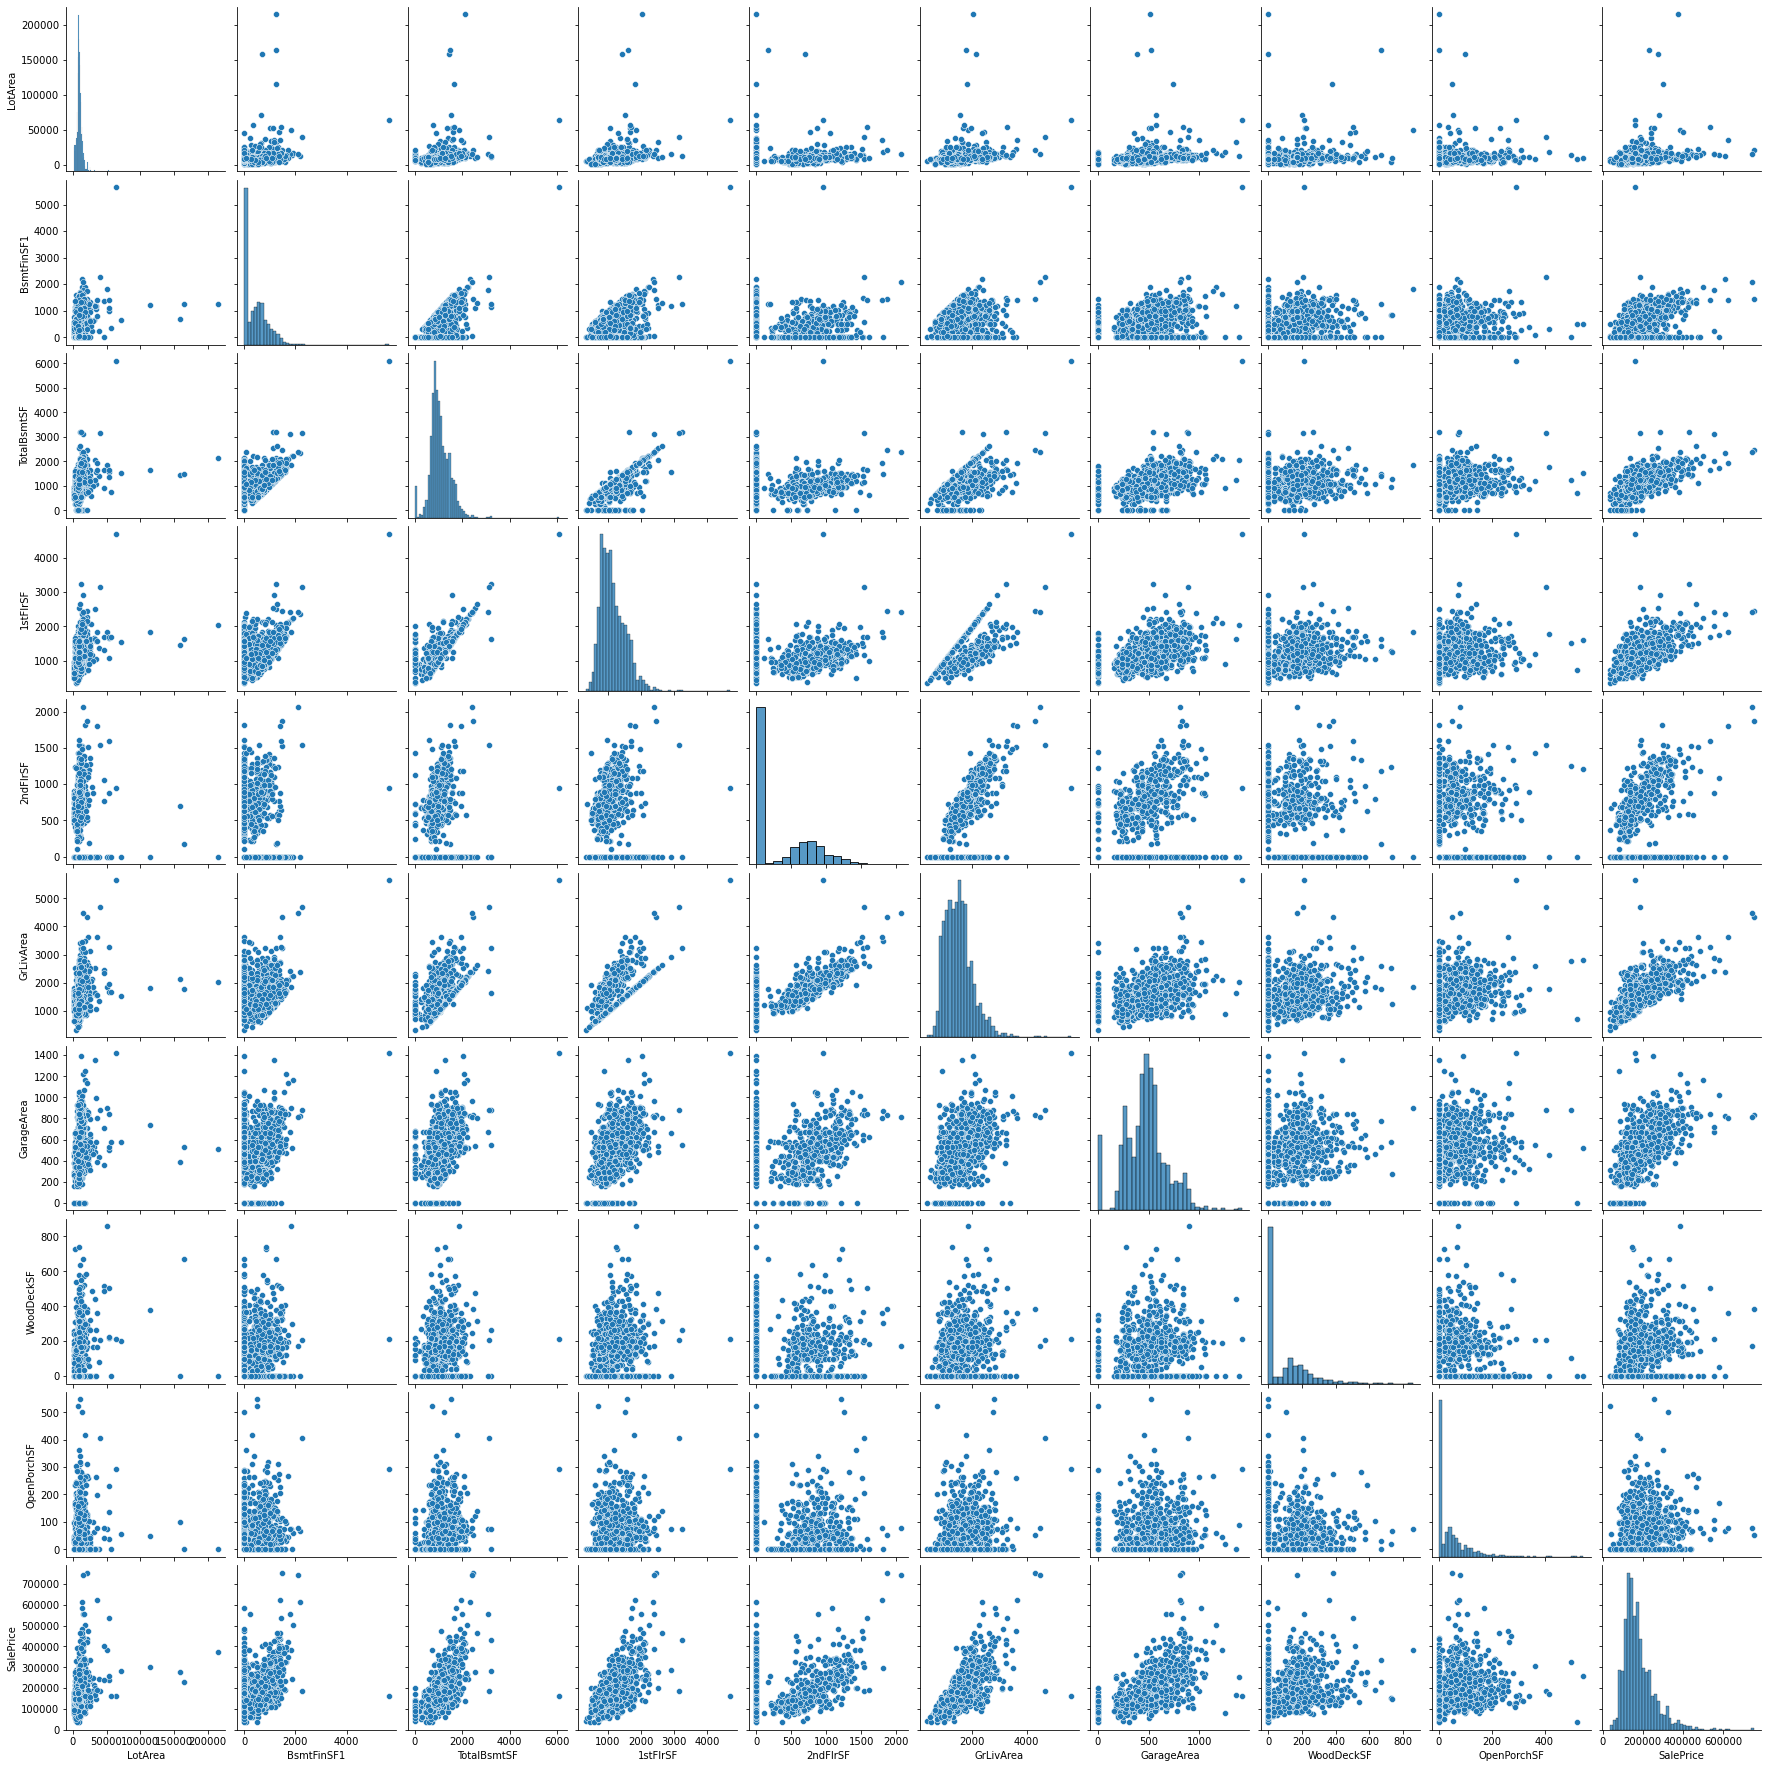

In [23]:
Z = pd.concat([num_train[continues_features],y],axis=1)
sb.pairplot(Z)

## Aplicando transformacion logaritmica

In [24]:
y = np.log(y)
y.head()

0    12.247694
1    12.109011
2    12.317167
3    11.849398
4    12.429216
Name: SalePrice, dtype: float64

In [25]:
num_train = np.log1p(num_train)
num_train.head()

,YearRemodAdd,YearBuilt,WoodDeckSF,TotalBsmtSF,TotRmsAbvGrd,OverallQual,OpenPorchSF,LotArea,HalfBath,GrLivArea,GarageCars,GarageArea,FullBath,Fireplaces,BsmtFinSF1,2ndFlrSF,1stFlrSF
0,7.602900,7.602900,0.000000,6.753438,2.197225,2.079442,4.127134,9.042040,0.693147,7.444833,1.098612,6.308098,1.098612,0.000000,6.561031,6.751101,6.753438
1,7.589336,7.589336,5.700444,7.141245,1.945910,1.945910,0.000000,9.169623,0.000000,7.141245,1.098612,6.133398,1.098612,0.693147,6.886532,0.000000,7.141245
2,7.602401,7.601902,0.000000,6.825460,1.945910,2.079442,3.761200,9.328212,0.693147,7.488294,1.098612,6.411818,1.098612,0.693147,6.188264,6.765039,6.825460
3,7.586296,7.557995,0.000000,6.629363,2.079442,2.079442,3.583519,9.164401,0.000000,7.448916,1.386294,6.466145,0.693147,0.693147,5.379897,6.629363,6.869014
4,7.601402,7.601402,5.262690,7.044033,2.302585,2.197225,4.442651,9.565284,0.693147,7.695758,1.386294,6.729824,1.098612,0.693147,6.486161,6.960348,7.044033


--

ValueError: Could not interpret input 'HasBsmt'

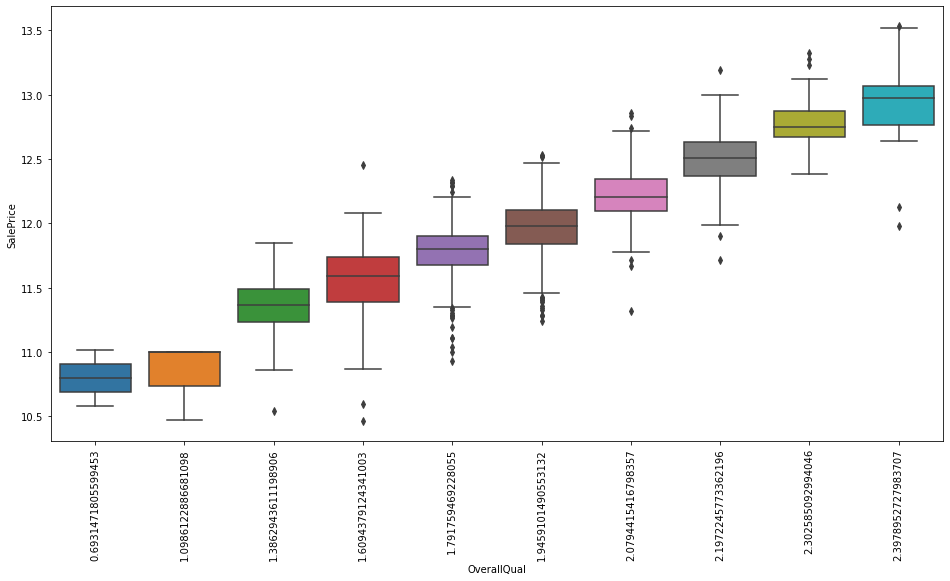

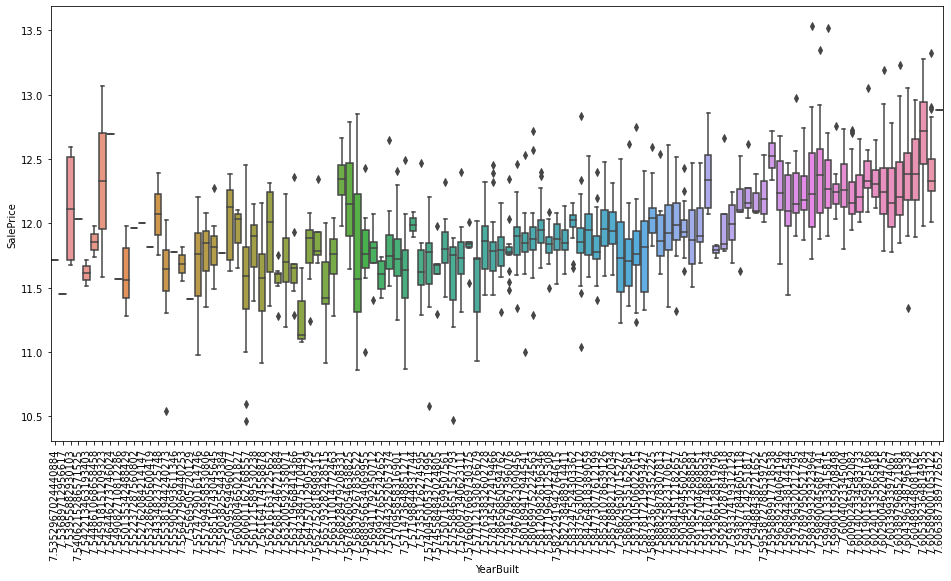

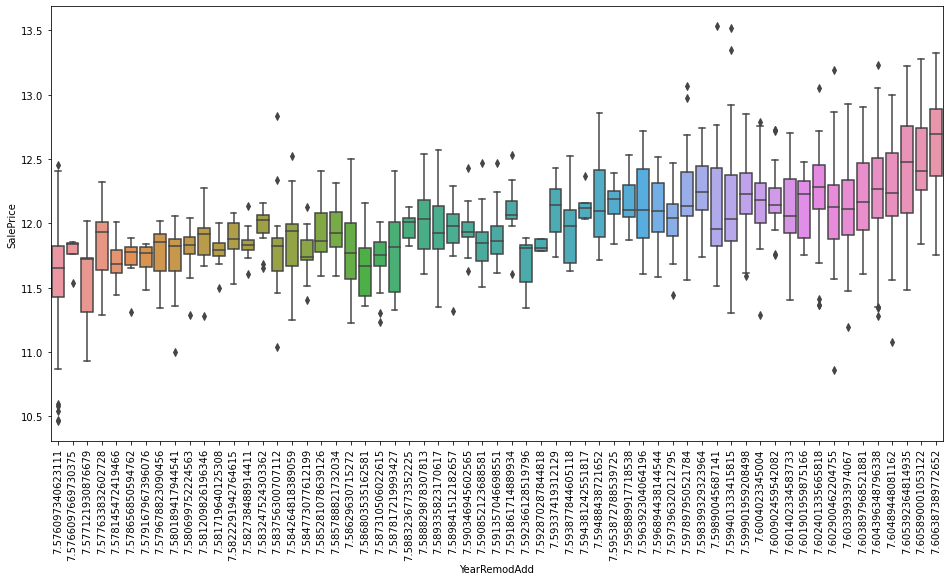

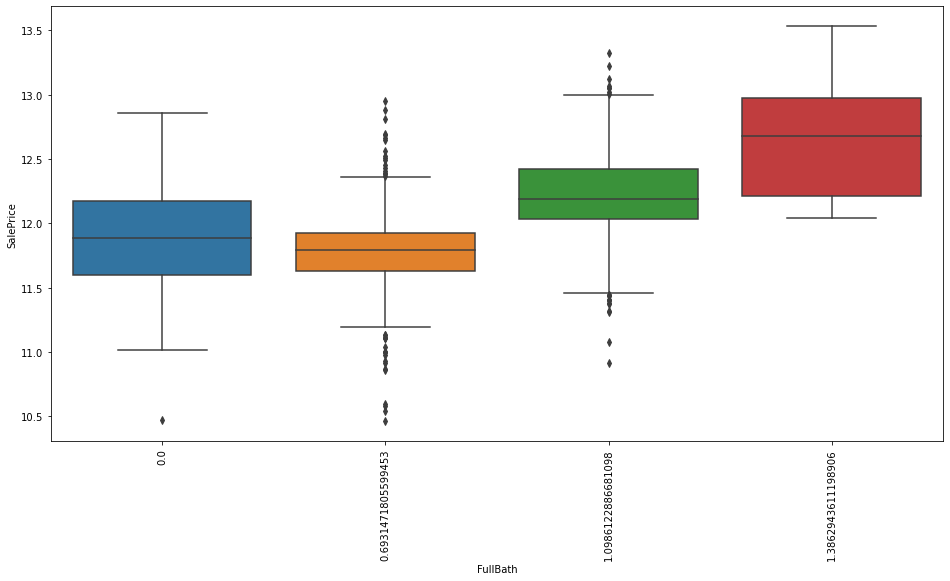

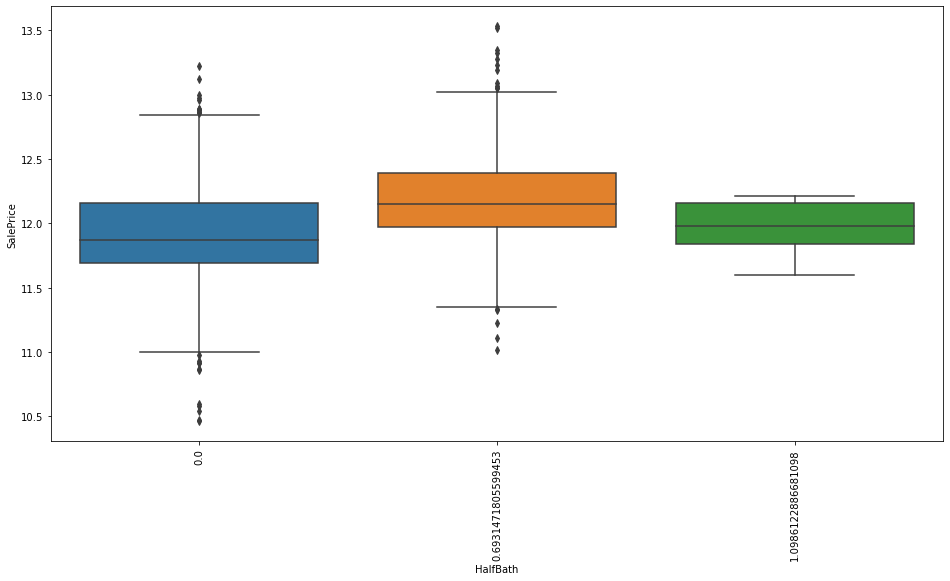

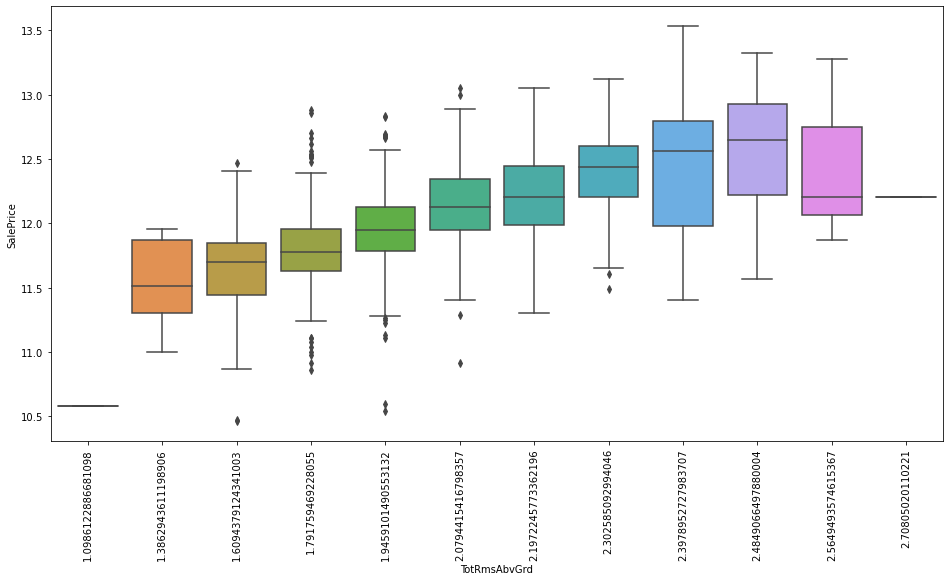

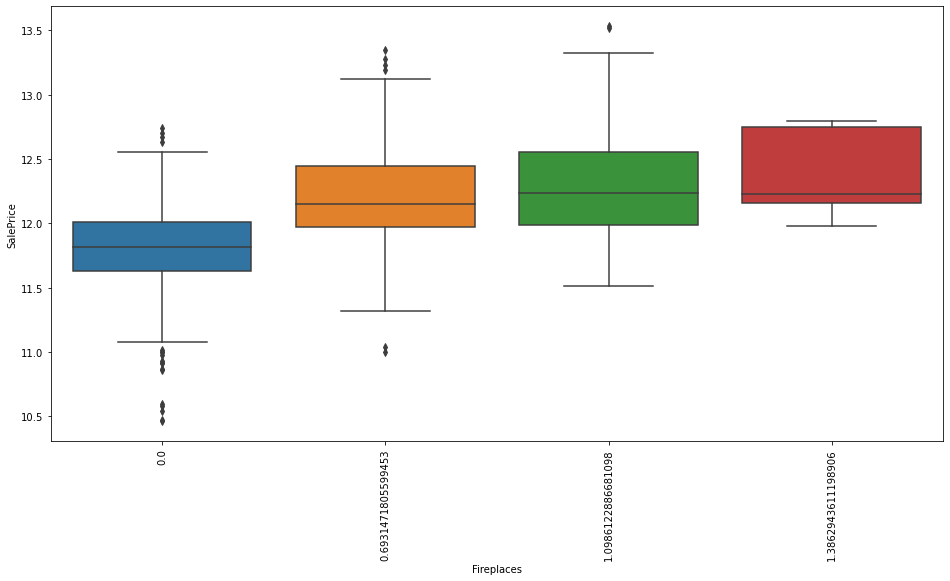

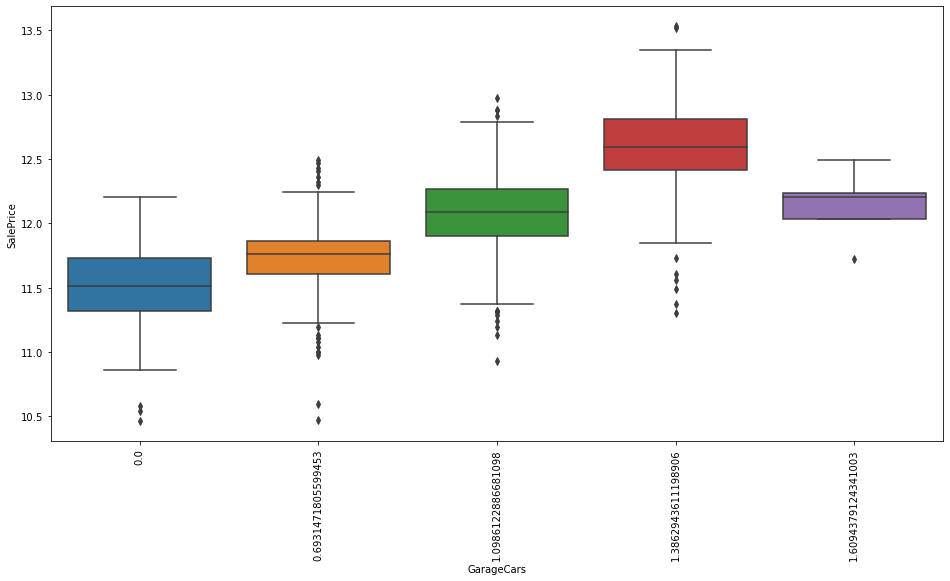

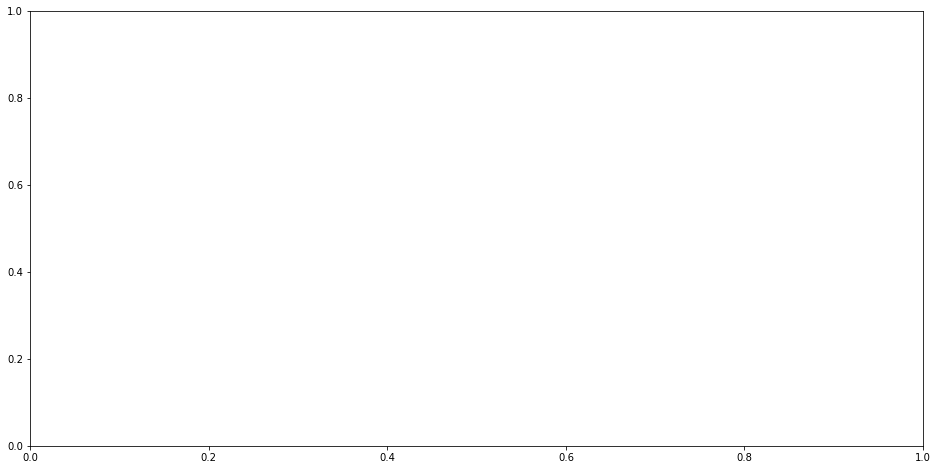

In [26]:
for feature in not_continues:
    data = pd.concat([num_train, y], axis=1)
    f, ax = plt.subplots(figsize=(16, 8))
    fig = sb.boxplot(x=feature, y="SalePrice", data=data)
    plt.xticks(rotation=90);

## Now let's continue with categoricals

In [27]:
cat = train.dtypes == "object"
cat

MSSubClass       False
MSZoning          True
LotArea          False
Street            True
LotShape          True
                 ...  
MiscVal          False
MoSold           False
YrSold           False
SaleType          True
SaleCondition     True
Length: 61, dtype: bool

In [28]:
cat_cols = [c for c in cat.index if cat[c]]
cat_cols

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [29]:
cat_train = train[cat_cols]

In [30]:
cat_train.notnull().apply(pd.Series.value_counts)

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Foundation,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,PavedDrive,SaleType,SaleCondition
True,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,...,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459


MSZoning


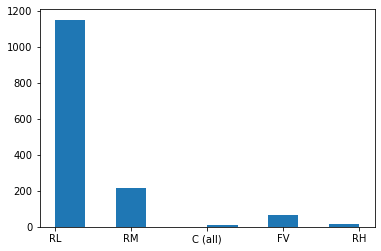

Street


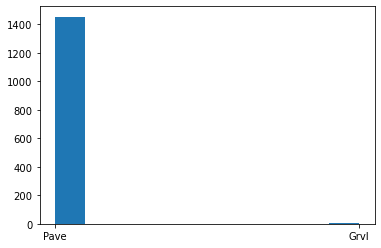

LotShape


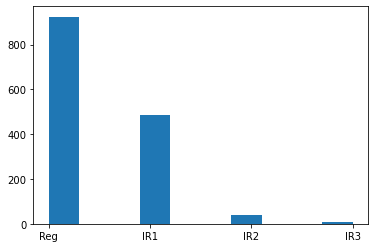

LandContour


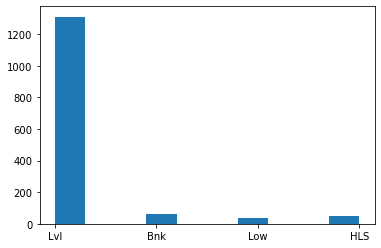

Utilities


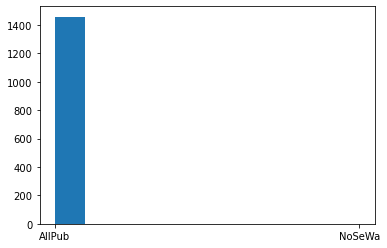

LotConfig


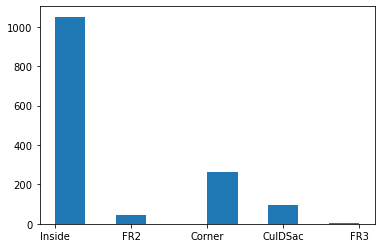

LandSlope


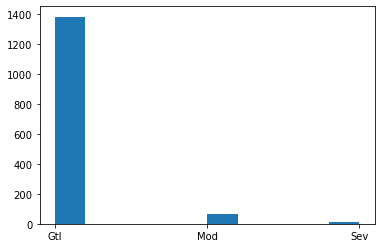

Neighborhood


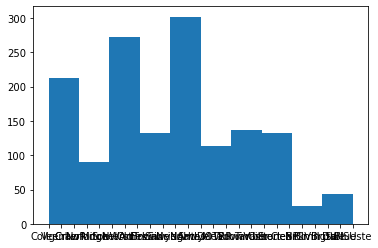

Condition1


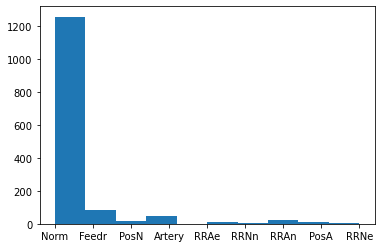

Condition2


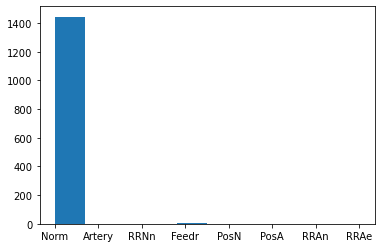

BldgType


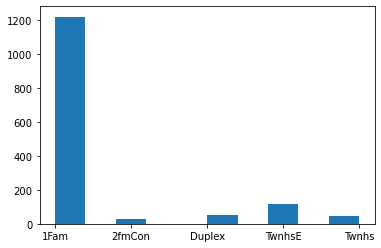

HouseStyle


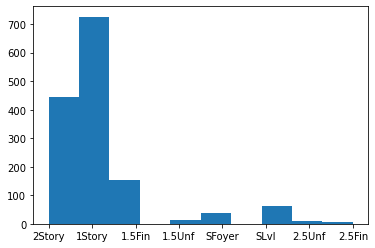

RoofStyle


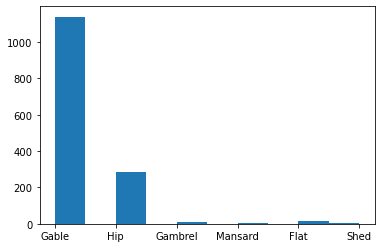

RoofMatl


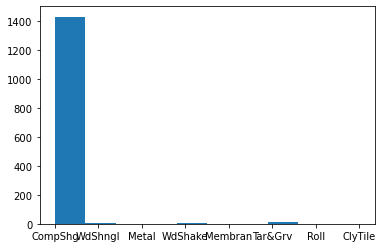

Exterior1st


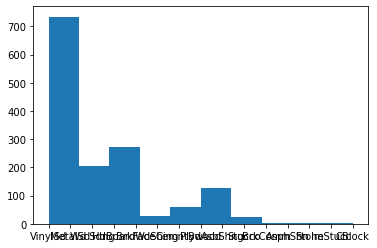

Exterior2nd


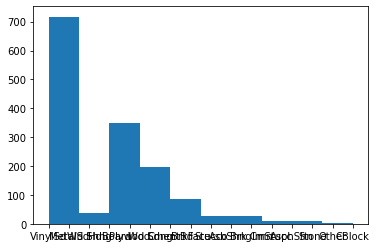

ExterQual


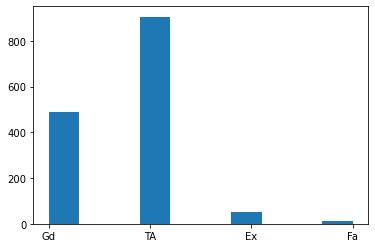

ExterCond


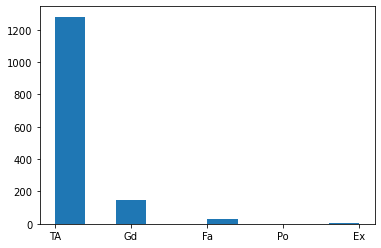

Foundation


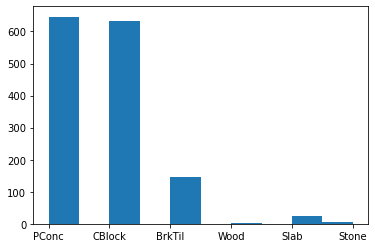

Heating


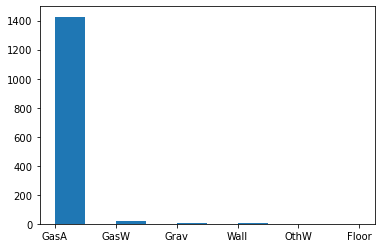

HeatingQC


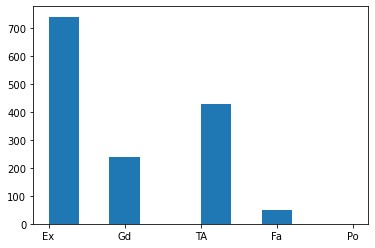

CentralAir


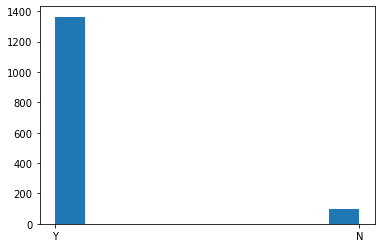

Electrical


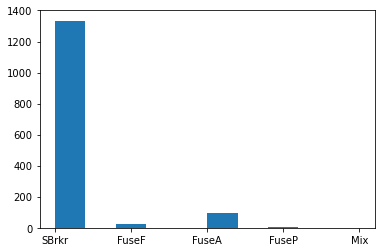

KitchenQual


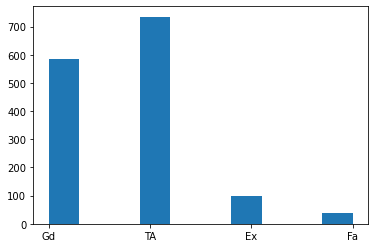

Functional


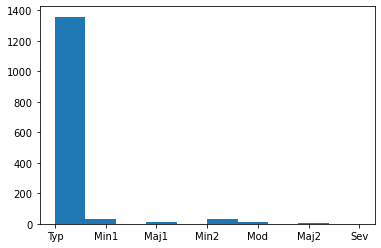

PavedDrive


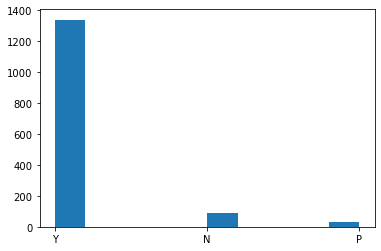

SaleType


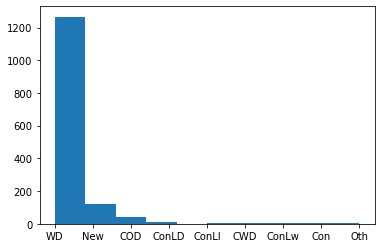

SaleCondition


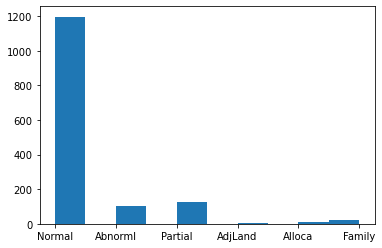

In [31]:
for x in cat_cols:
#    cat_train[x].hist()
    print(x)
    plt.hist(cat_train[x], bins = 10)
    plt.xticks()
    plt.show()

In [32]:
cat_train_dummies = pd.get_dummies(cat_train, drop_first=True)
cat_train_dummies.head()

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [33]:
train = pd.concat([num_train, cat_train_dummies], axis = 1)
# train = pd.concat([num_train, cat_train], axis = 1)

## Test with LinearRegression model and train_test_split

In [34]:
x_train, x_validation, y_train, y_validation = train_test_split(train, y, test_size= .25, random_state = 1)

In [35]:
regressor = LinearRegression()
regressor.fit(x_train, y_train)

LinearRegression()

In [36]:
regressor.score(x_validation, y_validation)

0.8301830878143187

## Applying cross validation

In [37]:

#LinearRegression
regressor = LinearRegression()
#Lasso
#regressor = Lasso()
results = cross_validate(regressor,train,y,return_train_score=True,cv=5)
results

{'fit_time': array([0.02207088, 0.02107048, 0.02006531, 0.02107024, 0.01805735]),
 'score_time': array([0.00401473, 0.00401282, 0.00702357, 0.00401163, 0.00602031]),
 'test_score': array([0.81749228, 0.87552043, 0.86621269, 0.89199758, 0.8423196 ]),
 'train_score': array([0.92970357, 0.93599968, 0.93774732, 0.93517423, 0.935292  ])}

In [38]:
results['test_score'].mean()

0.858708515787496

## Test with RandomForest

First use grid search to look for better params

In [39]:
from sklearn.model_selection import GridSearchCV

param_grid = [
{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
scoring='neg_mean_squared_error',
return_train_score=True)

grid_search.fit(train, y)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [40]:
cvres = grid_search.cv_results_
cvres

{'mean_fit_time': array([0.0511703 , 0.03631988, 0.09190373, 0.01605301, 0.03732338,
        0.09170303, 0.01525021, 0.03973155, 0.09732242, 0.0184608 ,
        0.05076795, 0.12220359, 0.01605396, 0.03491511, 0.01745729,
        0.03611865, 0.01444745, 0.03932996]),
 'std_fit_time': array([0.06973293, 0.00293483, 0.00894283, 0.00089665, 0.00704859,
        0.0095098 , 0.00293551, 0.00548037, 0.00631383, 0.00583717,
        0.00794163, 0.0186679 , 0.00063399, 0.0036678 , 0.0013609 ,
        0.00297607, 0.00049154, 0.00408288]),
 'mean_score_time': array([0.00742474, 0.00582032, 0.0086288 , 0.00421472, 0.00541945,
        0.00782633, 0.00441518, 0.00521817, 0.0078259 , 0.00461626,
        0.00622082, 0.0086298 , 0.0050159 , 0.00501671, 0.00441599,
        0.00541925, 0.00421505, 0.00622106]),
 'std_score_time': array([5.83568859e-03, 1.17039981e-03, 8.02374120e-04, 7.51655027e-04,
        4.92065414e-04, 7.51195690e-04, 8.03041494e-04, 7.51158741e-04,
        4.01520740e-04, 1.20405398e-

It seems that a more complex algorithm is not good for this

In [41]:
from sklearn.ensemble import GradientBoostingRegressor

ensemble = GradientBoostingRegressor()
results = cross_validate(ensemble,train,y,cv=5,scoring='r2',return_train_score=True)

In [42]:
test_scores = results['test_score']
train_scores = results['train_score']
print(np.mean(train_scores))
print(np.mean(test_scores))

0.9530291476900011
0.886193072043028


It seems that Gradient has more score

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, y, random_state = 1)

In [44]:
param_test1 = {'n_estimators': range(20,500,20)}
estimators = GradientBoostingRegressor(learning_rate = 0.1,
                                      min_samples_split=500,
                                      min_samples_leaf = 50,
                                      max_depth=8,
                                      subsample= 0.8,
                                      random_state = 10)
#Esto es una receta

In [45]:
gsearch_gradient = GridSearchCV(estimators,
                      param_grid = param_test1,
                      scoring='r2',
                      cv=5)

In [46]:
gsearch_gradient.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
list(zip(gsearch_gradient.cv_results_['mean_test_score'], gsearch_gradient.cv_results_['std_test_score'], gsearch_gradient.cv_results_['params']))

In [47]:
estimator = GradientBoostingRegressor(max_depth=8, min_samples_leaf=50,
                          min_samples_split=500, n_estimators=360,
                          random_state=10, subsample=0.8)

In [48]:
estimator.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=8, min_samples_leaf=50,
                          min_samples_split=500, n_estimators=360,
                          random_state=10, subsample=0.8)

In [49]:
estimator.score(X_test,y_test)

0.8621619364314839

## To do: predict with test.csv and make plots about it

In [74]:
# Para hacer un pipeline
# 1. Eliminar los nulos
# 2. Dejar solo los que tengan una correlacion mas de 0.25
# 3 Aplicar transformacion logaritmica en todos los datos numericos
# 4 Aplicar dummy data en variables categoricas

def clean_null_values(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    
    #dealing with missing data
    df = df.drop((missing_data[missing_data['Total'] > 3]).index,1)
    df = df.drop(df.loc[df['Electrical'].isnull()].index)
    df.isnull().sum().max() #just checking that there's no missing data missing...
    
    return df

def transform_numeric_and_categoric_values(df, important_features):
    num = df.dtypes != "object"
    num_cols = [c for c in num.index if num[c]]

    num_train = df[num_cols].copy()
    num_train = num_train[important_features]
    num_train = np.log1p(num_train)
    
    cat = df.dtypes == "object"
    
    cat_cols = [c for c in cat.index if cat[c]]
    cat_cols
    
    cat_train = df[cat_cols]
    cat_train_dummies = pd.get_dummies(cat_train, drop_first=True)
    df = pd.concat([num_train, cat_train_dummies], axis = 1)
    return df

def imputer_for_null_values(df):
    imputer = SimpleImputer(strategy="median")
    imputer.fit(df)
    X_trans = imputer.transform(df)
    return X_trans

In [75]:
df_test = test.copy()
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [76]:
df_test = clean_null_values(df_test)
df_test = transform_numeric_and_categoric_values(df_test, important_features)
df_test = imputer_for_null_values(df_test)

# Lets test with real data

In [77]:
ensemble = GradientBoostingRegressor()
estimator = GradientBoostingRegressor(max_depth=8, min_samples_leaf=50,
                          min_samples_split=500, n_estimators=360,
                          random_state=10, subsample=0.8)
estimator.fit(train, y)

GradientBoostingRegressor(max_depth=8, min_samples_leaf=50,
                          min_samples_split=500, n_estimators=360,
                          random_state=10, subsample=0.8)

In [78]:
estimator.predict(df_test)

ValueError: Number of features of the model must match the input. Model n_features is 176 and input n_features is 157 

In [55]:
df_test.notnull().apply(pd.Series.value_counts)

,YearRemodAdd,YearBuilt,WoodDeckSF,TotalBsmtSF,TotRmsAbvGrd,OverallQual,OpenPorchSF,LotArea,HalfBath,GrLivArea,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
False,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
True,1459.0,1459.0,1459.0,1458,1459.0,1459.0,1459.0,1459.0,1459.0,1459.0,...,1459.0,1459.0,1459.0,1459.0,1459.0,1459.0,1459.0,1459.0,1459.0,1459.0
